In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [2]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [3]:
movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

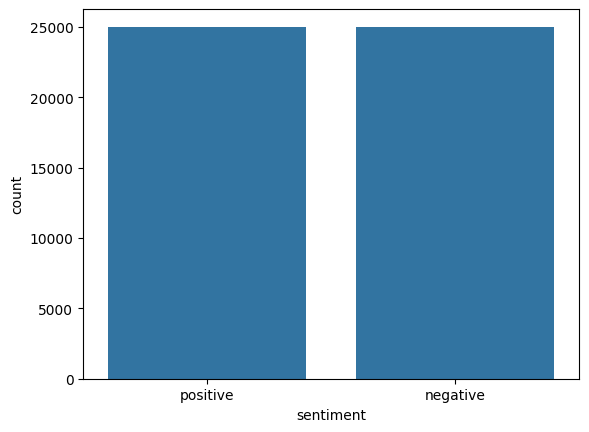

In [6]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [7]:
movie_reviews["review"][2]
# text contains punctuations, brackets, HTML tags and numbers

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

# pattern '<[^>]+>' matches anything between opening and closing angle brackets (< and >). [^>]+ means one or more characters that are not >. So, this pattern effectively matches HTML tags.

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
    return TAG_RE.sub('', text)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raoha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [11]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase'''
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)   # sub -> substitution
    # ' ' is the replacement string

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # \s+: Matches one or more whitespace characters
    # raw string literal r" " is used to avoid escaping backslashes

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    # \b: Matches a word boundary, ensuring that the stopwords are matched as whole words.
    # r'|'.join(stopwords.words('english')): This part of the code joins all the English stopwords with a | (OR) operator.
    
    sentence = pattern.sub('', sentence)

    return sentence

In [12]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))


In [13]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [14]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Embedding Layer

In [16]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

In [17]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [18]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32') 
    #This extracts the vector dimensions of the word embedding from the remaining elements of the records list. 
    #The asarray() function converts the vector dimensions to a NumPy array with data type 'float32'.
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Words that do not have pretrained embeddings will have a row of zeros in the embedding matrix. 
# This embedding matrix can then be used to initialize the embedding layer of a neural network model for natural language processing tasks, allowing the model to leverage pretrained word embeddings during training.

In [21]:
embedding_matrix.shape

(92394, 100)

## Model Training

### Simple Neural Network

In [23]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [24]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# batch_size=128: This parameter specifies the number of samples per gradient update.
# verbose=1: This parameter controls the verbosity of the training process. Setting it to 1 means that progress bars will be displayed during training, showing the training and validation metrics for each epoch.

Epoch 1/6
250/250 [==============================] - 2s 5ms/step - loss: 0.5607 - acc: 0.7126 - val_loss: 0.5240 - val_acc: 0.7527
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4510 - acc: 0.7933 - val_loss: 0.5059 - val_acc: 0.7573
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4137 - acc: 0.8151 - val_loss: 0.5041 - val_acc: 0.7631
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3912 - acc: 0.8280 - val_loss: 0.5089 - val_acc: 0.7619
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3764 - acc: 0.8344 - val_loss: 0.5250 - val_acc: 0.7613
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3644 - acc: 0.8407 - val_loss: 0.5289 - val_acc: 0.7582


In [25]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5563 - acc: 0.7515


In [26]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5562606453895569
Test Accuracy: 0.7515000104904175


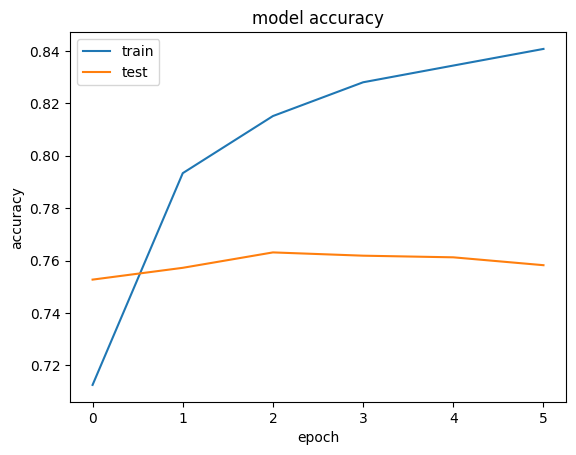

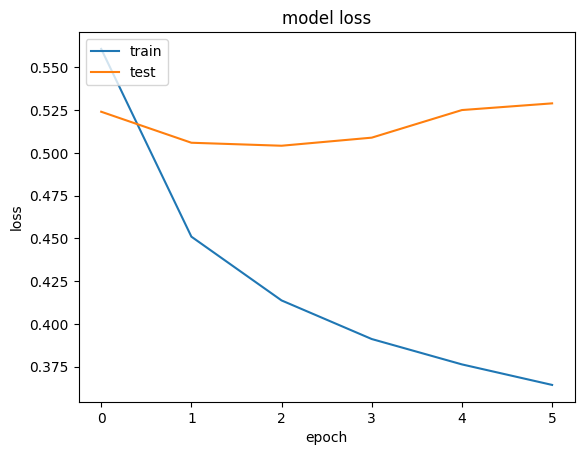

In [27]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Ideally, both the training and validation accuracies should increase over epochs, indicating that the model is learning and generalizing well to unseen data. 
# However, if the validation accuracy starts to decrease while the training accuracy continues to increase, it might indicate overfitting, where the model is memorizing the training data instead of learning general patterns.

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Ideally, both the training and validation losses should decrease over epochs, indicating that the model is improving its predictions. 
# However, if the validation loss starts to increase while the training loss continues to decrease, it might indicate overfitting

### Convolutional Neural Network

In [28]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [29]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 9s 34ms/step - loss: 0.4630 - acc: 0.7803 - val_loss: 0.3812 - val_acc: 0.8375
Epoch 2/6
250/250 [==============================] - 9s 35ms/step - loss: 0.3348 - acc: 0.8586 - val_loss: 0.3496 - val_acc: 0.8493
Epoch 3/6
250/250 [==============================] - 8s 32ms/step - loss: 0.2808 - acc: 0.8890 - val_loss: 0.3417 - val_acc: 0.8503
Epoch 4/6
250/250 [==============================] - 8s 31ms/step - loss: 0.2393 - acc: 0.9105 - val_loss: 0.3366 - val_acc: 0.8551
Epoch 5/6
250/250 [==============================] - 8s 33ms/step - loss: 0.2030 - acc: 0.9294 - val_loss: 0.3469 - val_acc: 0.8501
Epoch 6/6
250/250 [==============================] - 8s 31ms/step - loss: 0.1651 - acc: 0.9507 - val_loss: 0.3413 - val_acc: 0.8522


In [30]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 5ms/step - loss: 0.3389 - acc: 0.8557


In [31]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3389245867729187
Test Accuracy: 0.8557000160217285


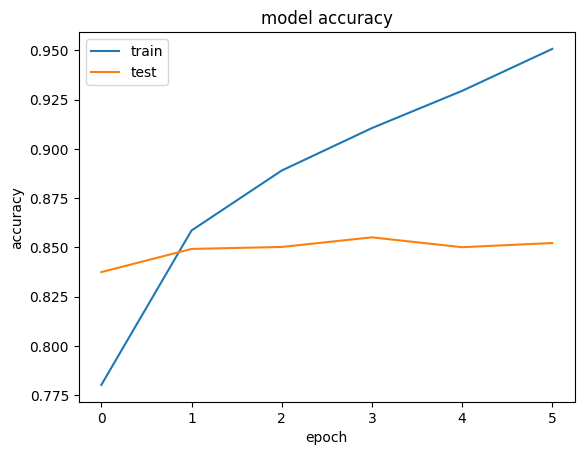

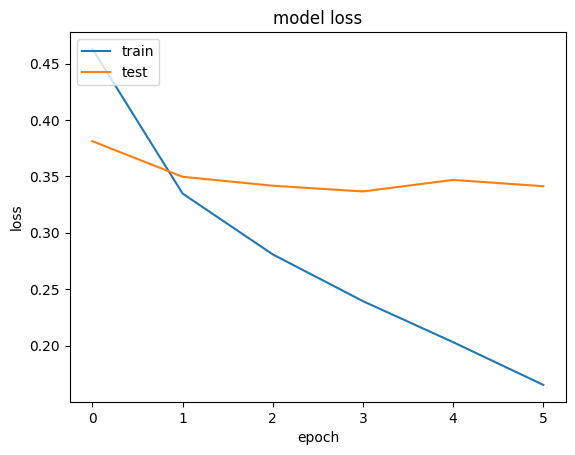

In [32]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### Recurrent Neural Network (LSTM - Long Short Term Memory)

In [33]:
from keras.layers import LSTM

In [34]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [35]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 47s 182ms/step - loss: 0.5126 - acc: 0.7487 - val_loss: 0.4371 - val_acc: 0.7994
Epoch 2/6
250/250 [==============================] - 50s 199ms/step - loss: 0.4248 - acc: 0.8108 - val_loss: 0.3981 - val_acc: 0.8324
Epoch 3/6
250/250 [==============================] - 50s 199ms/step - loss: 0.3759 - acc: 0.8390 - val_loss: 0.3471 - val_acc: 0.8480
Epoch 4/6
250/250 [==============================] - 48s 193ms/step - loss: 0.3444 - acc: 0.8519 - val_loss: 0.3387 - val_acc: 0.8459
Epoch 5/6
250/250 [==============================] - 50s 200ms/step - loss: 0.3247 - acc: 0.8631 - val_loss: 0.3230 - val_acc: 0.8601
Epoch 6/6
250/250 [==============================] - 49s 196ms/step - loss: 0.3130 - acc: 0.8687 - val_loss: 0.3239 - val_acc: 0.8589


In [36]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 8s 25ms/step - loss: 0.3280 - acc: 0.8545


In [37]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.32799673080444336
Test Accuracy: 0.8544999957084656


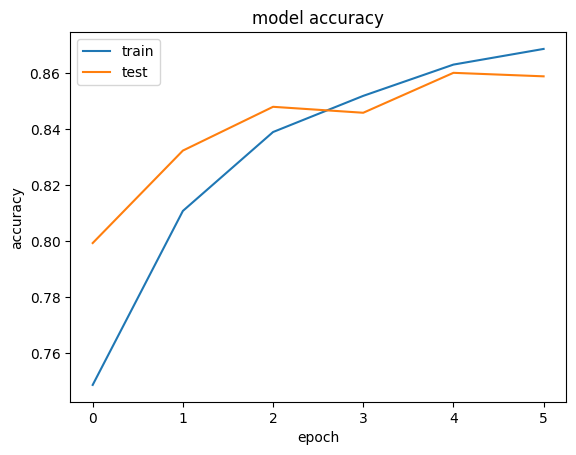

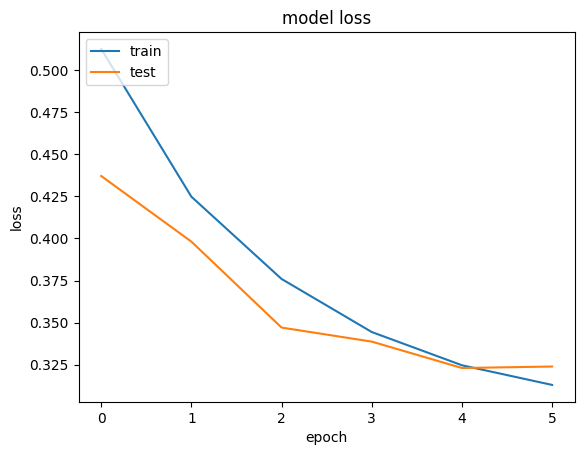

In [38]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [43]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

c:\Users\raoha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Making prediction on IMDB data

In [46]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='./c1_lstm_model_acc_0.854.h5'
pretrained_lstm_model = load_model(model_path)

pretrained_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [47]:
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [48]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 1s/step


array([[0.87303346],
       [0.98975813],
       [0.19766912],
       [0.40793094],
       [0.96031463],
       [0.01860765]], dtype=float32)

In [49]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.7
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.0
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,4.1
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.6
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2
